In [4]:
!ls ./drive/My\ Drive | grep -P ".jpg" | xargs -d "\n" -L1 -I "$" echo "./drive/My Drive/$" | xargs -d "\n" rm

rm: missing operand
Try 'rm --help' for more information.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!unzip ./drive/My\ Drive/Colab\ Notebooks/data.zip

Archive:  ./drive/My Drive/Colab Notebooks/data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# DCGAN
GAN = Generator + Discriminator

## Generator
(ConvTranspose2d + BatchNorm + ReLU) \* 4 + ConvTranspose2d + Tanh

In [0]:
import torch.nn as nn

In [0]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

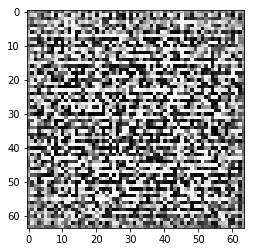

In [10]:
G = Generator(z_dim=20, image_size=64)
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

## Discriminator
Vanilla CNN (Activation func. = LeakyReLU)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

In [12]:
D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

d_out = D(fake_images)

print(nn.Sigmoid()(d_out))

tensor([[[[0.4961]]]], grad_fn=<SigmoidBackward>)


## DataLoader

In [0]:
from torchvision import transforms
import torch.utils.data as data
from PIL import Image
import torch

In [0]:
def make_datapath_list():
    train_img_list = list()
    
    for img_idx in range(200):
        img_path = './data/img_78/img_7_'+ str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './data/img_78/img_8_'+str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.data_transform(img)
    
class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img)
        
        return img_transformed

In [0]:
# Dataset
train_img_list = make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list = train_img_list, transform = ImageTransform(mean, std))

# DataLoader
batch_size=64
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [16]:
batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size())

torch.Size([64, 1, 64, 64])


## Train DCGAN

In [0]:
import torch.nn as nn

In [18]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Initialize Conv2d and ConvTranspose2d
        nn.init.normal_(m.weight.data, 0., 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # Initialize BatchNorm2d
        nn.init.normal_(m.weight.data, 1., 0.02)
        nn.init.constant_(m.bias.data, 0)
        
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [0]:
import time

In [0]:
def train_model(G, D, dataloader, num_epochs):
    # Device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )
    
    # Optimizer
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0., .9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    # Loss
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    z_dim = 20
    mini_batch_size = 64
    
    # Put models to GPU
    G.to(device)
    D.to(device)
    
    G.train()
    D.train()
    
    torch.backends.cudnn.benchmark = True
    
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    iteration = 1
    logs = []
    
    # epoch
    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        epoch_g_loss = 0.
        epoch_d_loss = 0.
        
        print('----------------')
        
        for imges in dataloader:
            
            #-----------------------------
            #Train Discriminator
            #-----------------------------
            
            if imges.size()[0] == 1:
                continue
                
            imges = imges.to(device)
            
            # Labels
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)
            
            # Evaluate real images
            d_out_real = D(imges)
            
            # Make fake images and Evaluate those images
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            # Calculate loss
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            # Backpropagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
            #------------------------
            # Generator
            #------------------------
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            
            # Loss
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            # Backpropagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        t_epoch_finish = time.time()
        print('---------------')
        print('epoch {} || Epch_D_Loss:{:.4f} || Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        
    return G,D
            

In [ ]:
num_epochs = 200
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs
)

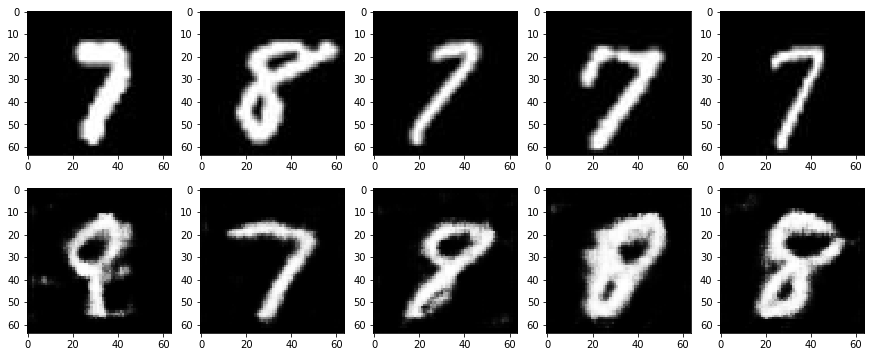

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
  plt.subplot(2, 5, i+1)
  plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')
  
  plt.subplot(2, 5, 5+i+1)
  plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

# Self-Attention GAN

## Self Attention Class

In [0]:
import torch.nn as nn
import torch

In [0]:
class Self_Attention(nn.Module):
  def __init__(self, in_dim):
    super(Self_Attention, self).__init__()
    # Pointwise convolution
    self.query_conv =nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
    self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
    self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
    
    # Softmax for normalizing Attention Map
    self.softmax = nn.Softmax(dim=-2)
    
    # output = x + gamma*o
    # gamma is a learnable parameter.
    self.gamma = nn.Paramter(torch.zeros(1))
  
  def forward(self,x):
    X = x
    
    # B x C x W x H -> B x C' x N
    proj_query = self.query_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
    proj_query = proj_query.permute(0, 2, 1)
    proj_key = self.key_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
    
    # xt * x
    S = torch.bmm(proj_query, proj_key)
    
    # Normalizing attention map
    attention_map_T = self.softmax(S)
    attention_map = attention_map_T.permute(0, 2, 1)
    
    # Self-Attention Map
    proj_value = self.value_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
    o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))
    
    o = o.view(X.shpae[0], X.shape[1], X.shape[2], X.shape[3])
    out = x+self.gamma*o
    
    return out, attention_map
    

## Generator Class

In [0]:
class Generator(nn.Module):
  def __init__(self, z_dim=20, image_size=64):
    super(Generator, self).__init__()
    
    self.layer1 = nn.Sequential(
        nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1)),
        nn.BatchNorm2d(image_size*8),
        nn.ReLU(inplace=True)
    )
    
    self.layer2 = nn.Sequential(
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size *8, image_size*4, kernel_size=4, stride=2, padding=1)),
        nn.BatchNorm2d(image_size*4),
        nn.ReLU(inplace=True)
    )
    
    self.layer3 = nn.Sequential(
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1)),
        nn.BatchNorm2d(image_size*2),
        nn.ReLU(inplace=True)
    )
    
    self.self_attention1 = Self_Attention(in_dim=image_size*2)
    
    self.layer4 = nn.Sequential(
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1)),
        nn.BatchNorm2d(image_size),
        nn.ReLU(inplace=True)
    )
    
    self.self_attention2 = Self_Attention(in_dim=image_size)
    
    self.last = nn.Sequential(
        nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )
    
    self.self_attention2 = Self_Attention(in_dim=64)
 
  def forward(self, z):
    out = self.layer1(z)
    out = self.layer2(out)
    out = self.layer3(out)
    out, attention_map1 = self.self_attention1(out)
    out = self.layer4(out)
    out, attention_map2 = self.self_attention2(out)
    out = self.last(out)
    
    return out


## Discriminator Class

In [0]:
class Discriminator(nn.Module):
  def __init__(self, z_dim=20, image_size=64):
    super(Discriminator, self).__init__()
    
    self.layer1 = nn.Sequential(
        nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.1, inplace=True)
    )
    
    self.layer2 = nn.Sequential(
        nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.1, inplace=True)
    )
    
    self.layer3 = nn.Sequential(
        nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.1,inplace=True)
    )
    
    self.self_attention1 = SelfAttention(in_dim=image_size*8)
    
    self.layer4 = nn.Sequential(
        nn.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1)),
        nn.LeakyReLU(0.1, inplace=True)
    )
    
    self.self_attention2 = SelfAttention(in_dim=image_size*8)
    
    self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
    
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out, attention_map1 = self.self_attention1(out)
    out = self.layer4(out)
    out, attention_map2 = self.self_attention2(out)
    out = self.last(out)
    
    return out

## Train Model

In [0]:
def train_model(G,D, dataloader, num_epochs):
  # GPU
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
  # Optimizer
  g_lr, d_lr = 0.0001, 0.0004
  beta1, beta2 = 0.0, 0.9
  g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
  d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
  
  z_dim =20
  mini_batch_size=64
  
  G.to(device)
  D.to(device)
  
  G.train()
  D.train()
  
  torch.backends.benchmark = True
  
  num_train_imgs = len(dataloader.dataset)
  batch_size = dataloader.batch_size
  
  iteration = 1
  logs = []
  
  for epoch in range(num_epochs):
    t_epoch_start = time.time()
    epoch_g_loss = 0.
    epoch_d_loss = 0.
    
    print('-----------------')
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-----------------')
    print(' (train) ')
    
    for imges in dataloader:
      
      ### Discriminator
      if imges.size()[0] == 1:
        continue
        
      imges = imges.to(device)
      mini_batch_size = imges.size()[0]
      
      # Discriminate real images(all values are expected to be 1)
      d_out_real= D(imges)
      
      # Generate fake images and Discriminate those(all values are expected to be 0)
      input_z = torch.randn(mini_batch_size, z_dim).to(device)
      input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
      fake_images= G(input_z)
      d_out_fake= D(fake_images)
      
      # Calculate loss for each real and fake
      d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
      d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
      d_loss = d_loss_real + d_loss_fake
      
      # Optimize
      g_optimizer.zero_grad()
      d_optimizer.zero_grad()
      d_loss.backward()
      d_optimizer.step()
      
      ### Generator
      
      # Generate fake images and Discriminate those(0:fake, 1:real)
      input_z = torch.randn(mini_batch_size, z_dim).to(device)
      input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
      fake_images = G(input_z)
      d_out_fake = D(fake_images)
      
      # Calculate Loss: Generator wants D to output all 1s (wants it to think those real).
      # If all outputs are 1s, g_loss can be the minimum value.
      g_loss = - d_out_fake.mean()
      
      # Optimize
      g_optimizer.zero_grad()
      d_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()
      
      epoch_d_loss += d_loss.item()
      epoch_g_loss += g_loss.item()
      iteration += 1
      
    t_epoch_finish = time.time()
    print('----------------')
    print('epoch {} || Epoch_D_Loss:{:.4f} || Epoch_G_Loss:{:.4f}'.format(epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
    print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
    t_epoch_start = time.time()
    
  return G, D

## Initialize

In [ ]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    # Initialize Conv2d and ConvTranspose2d
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0)
  elif classname.find('BatchNorm') != -1:
    # Initialize BatchNorm
    nn.init.normal_(m.weight.data, 1., 0.02)
    nn.init.constant_(m.bias.data, 0)
    
G.apply(weights_init)
D.apply(weights_init)

num_epochs=300
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)


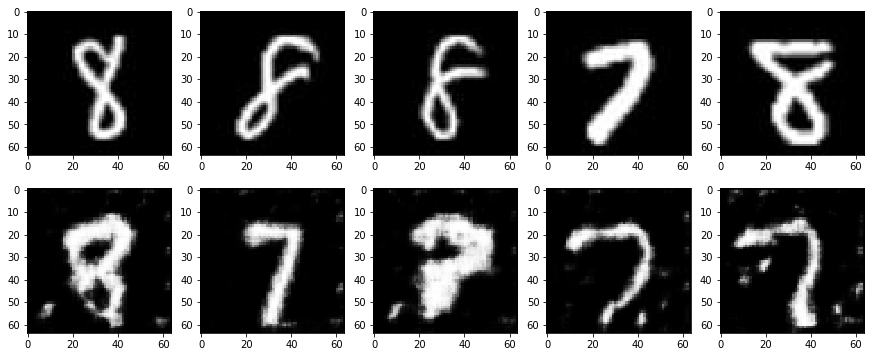

In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Random number
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
  plt.subplot(2, 5, i+1)
  plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')
  
  plt.subplot(2, 5, 5+i+1)
  plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')